In [1]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
import tensorflow as tf
from tensorflow import keras
from toai.imports import *
from toai.data import DataContainer, DataBundle
from gpu_helper import enable_gpu
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from model_utils import *

<IPython.core.display.Javascript object>

In [4]:
enable_gpu()

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


<IPython.core.display.Javascript object>

In [5]:
tf.get_logger().setLevel("ERROR")

<IPython.core.display.Javascript object>

In [16]:
DATA_DIR = Path("data")
TEMP_DIR = Path("temp")
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)
TOTAL_LENGTH = 1000

<IPython.core.display.Javascript object>

In [7]:
df = pd.read_json(DATA_DIR / "stupidstuff.json")

<IPython.core.display.Javascript object>

In [8]:
df.head()

,body,category,id,rating
0,A blackjack dealer and a player with a thirtee...,Children,1,2.63
1,"At a dinner party, several of the guests were ...",Blonde Jokes,2,2.57
2,One day this cop pulls over a blonde for speed...,Blonde Jokes,3,3.09
3,Three women are about to be executed for crime...,Blonde Jokes,4,4.10
4,A girl came skipping home FROM school one day....,Blonde Jokes,5,4.30


<IPython.core.display.Javascript object>

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3773 entries, 0 to 3772
Data columns (total 4 columns):
body        3773 non-null object
category    3773 non-null object
id          3773 non-null int64
rating      3773 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 118.0+ KB


<IPython.core.display.Javascript object>

In [11]:
df[df["body"] == ""]

,body,category,id,rating
1728,,Science,1729,4.5
1937,,Miscellaneous,1938,3.0
2949,,Animals,2950,2.0
2952,,Animals,2953,4.0
2953,,Animals,2954,5.0
...,...,...,...,...
3763,,Miscellaneous,3764,3.0
3766,,Miscellaneous,3767,4.0
3767,,Miscellaneous,3768,3.0
3768,,Miscellaneous,3769,5.0


<IPython.core.display.Javascript object>

In [12]:
df = df.loc[df["body"] != "", :].reset_index(drop=True)

<IPython.core.display.Javascript object>

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 4 columns):
body        3200 non-null object
category    3200 non-null object
id          3200 non-null int64
rating      3200 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 100.1+ KB


<IPython.core.display.Javascript object>

In [14]:
texts = []

for line in df["body"].values:
    line = re.sub(
        r"[^<>()\n,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz]",
        " ",
        line,
    )
    texts.append(line)

<IPython.core.display.Javascript object>

In [17]:
text_corpus = "\n<END>\n".join(df["body"].values[:TOTAL_LENGTH])
len(text_corpus)

840535

<IPython.core.display.Javascript object>

In [18]:
print(text_corpus[:TOTAL_LENGTH])

A blackjack dealer and a player with a thirteen count in his hand
were arguing about whether or not it was appropriate to tip the
dealer.

The player said, "When I get bad cards, it's not the dealer's fault.
Accordingly, when I get good cards, the dealer obviously had nothing
to do with it so, why should I tip him?"

The dealer said, "When you eat out do you tip the waiter?"

"Yes."

"Well then, he serves you food, I'm serving you cards, so you should
tip me."

"Okay, but, the waiter gives me what I ask for. I'll take an eight."
<END>
At a dinner party, several of the guests were arguing whether men or women were more trustworthy. 'No woman,' said one man, scornfully, 'can keep a secret.' 'I don't know about that,' answered a blonde woman guest. 'I have kept my age a secret since I was twenty-one.' 'You'll let it out some day,' the man insisted. 'I hardly think so!' responded the blonde lady. 'When a woman has kept a secret for twenty-seven years, she can keep it forever.'
<END>
One da

<IPython.core.display.Javascript object>

In [19]:
all_chars = "".join(sorted(set(text_corpus)))
all_chars

'\t\n !"#$%&\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_`abcdefghijklmnopqrstuvwxyz~\x94\x9d£Â×é–‘’“”…'

<IPython.core.display.Javascript object>

In [20]:
text_corpus = re.sub(
    r"[^ <>()\n,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz]",
    "",
    text_corpus,
)

<IPython.core.display.Javascript object>

In [22]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True, lower=False)

<IPython.core.display.Javascript object>

In [23]:
tokenizer.fit_on_texts(text_corpus)

<IPython.core.display.Javascript object>

In [24]:
tokenizer.texts_to_sequences(["Ain't this funny?"])

[[29, 9, 6, 3, 1, 3, 8, 9, 7, 1, 20, 13, 6, 6, 14, 35]]

<IPython.core.display.Javascript object>

In [25]:
[encoded_text] = np.array(tokenizer.texts_to_sequences([text_corpus])) - 1

<IPython.core.display.Javascript object>

In [26]:
dataset_size = tokenizer.document_count
train_size = int(dataset_size * 0.9)
vocabulary_size = len(tokenizer.word_index)
dataset_size, train_size, vocabulary_size

(824474, 742026, 75)

<IPython.core.display.Javascript object>

In [28]:
def make_dataset(data, vocabulary_size, window_length, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    dataset = dataset.shuffle(len(data) // 100).batch(batch_size)
    dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
    dataset = dataset.map(lambda xs, ys: (tf.one_hot(xs, depth=vocabulary_size), ys))
    return dataset

<IPython.core.display.Javascript object>

In [23]:
data_container = DataContainer(
    *DataBundle.split(
        data_bundle=DataBundle.from_dataframe(
            dataframe=df, x_col="body", y_col="category"
        ),
        fracs=[0.8, 0.1, 0.1],
    )
)

<IPython.core.display.Javascript object>

In [24]:
len(data_container.train), len(data_container.validation), len(data_container.test)

<IPython.core.display.Javascript object>

In [25]:
def make_dataset(data_bundle):
    return tf.data.Dataset.from_tensor_slices((data_bundle.x, data_bundle.y))

(128, 100, 75) (128, 100)
[ 0 22 12  2  0  3  6  0  6  7  1  0 10  4  1  6  0  6  4 20  0  6  7  1
  0  8  6  0  4 25  1  9 18  4 14  1  0 15  8  2  7  0 17  9  8  1 19 16
  0  0 31  7  1  0  2  3 23  1  6  0  2  7  1  0 17 12  5  0  3  5 10  0
 21  4  8  5  2  6  0  2  4  0  7  1  9  0  7  1  3 10 16  0 26  7  1  0
 22  4 13 19]
[22 12  2  0  3  6  0  6  7  1  0 10  4  1  6  0  6  4 20  0  6  7  1  0
  8  6  0  4 25  1  9 18  4 14  1  0 15  8  2  7  0 17  9  8  1 19 16  0
  0 31  7  1  0  2  3 23  1  6  0  2  7  1  0 17 12  5  0  3  5 10  0 21
  4  8  5  2  6  0  2  4  0  7  1  9  0  7  1  3 10 16  0 26  7  1  0 22
  4 13 19  9]


<IPython.core.display.Javascript object>

In [44]:
def make_vocabulary(dataset):
    vocabulary = Counter()
    for x, _ in dataset.batch(BATCH_SIZE).map(preprocess_batch):
        for review in x:
            vocabulary.update(review.numpy().tolist())
    return vocabulary

<IPython.core.display.Javascript object>

In [48]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)

<IPython.core.display.Javascript object>

In [49]:
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

Train for 5797 steps
Epoch 1/5
5797/5797 [==============================] - 298s 51ms/step - loss: 0.0660
Epoch 2/5
5797/5797 [==============================] - 298s 51ms/step - loss: 0.0199
Epoch 3/5
5797/5797 [==============================] - 297s 51ms/step - loss: 0.0185
Epoch 4/5
5797/5797 [==============================] - 297s 51ms/step - loss: 0.0177
Epoch 5/5
5797/5797 [==============================] - 297s 51ms/step - loss: 0.0171


<IPython.core.display.Javascript object>

In [50]:
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets=1)

<IPython.core.display.Javascript object>

In [51]:
def encode_words(x, y):
    return table.lookup(x), y

<IPython.core.display.Javascript object>

In [52]:
def encode_words(x, y):
    return table.lookup(x), y

<IPython.core.display.Javascript object>

In [53]:
train_dataset = (
    data_container.train.dataset.batch(BATCH_SIZE)
    .map(preprocess_batch)
    .map(encode_words)
    .repeat()
    .prefetch(-1)
)

<IPython.core.display.Javascript object>

In [54]:
validation_dataset = (
    data_container.validation.dataset.batch(BATCH_SIZE)
    .map(preprocess_batch)
    .map(encode_words)
    .repeat()
    .prefetch(-1)
)

<IPython.core.display.Javascript object>

In [56]:
GLOVE_DIR = TEMP_DIR / f"glove.6B.{EMBEDDING_DIM}d.txt"
embeddings_index = {}
f = open(GLOVE_DIR, encoding="utf-8")
print("Loading GloVe from:", GLOVE_DIR, "...", end=" ")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype="float32")
f.close()
print("Done.")

A blonde the bartender said, I could be the man and the bartender says, The bartender asks the same thing the bartender says the bottle bottle and and the bartender said, You dont do the bartender the man say
----
A blonde the bartender and the bartender have a contoned the bartender the bartender says, You was a bed and said, The man and the boy and the bartender then asks the parting and the contines and says, Well, 
----
A blonde store said to the door. The mon and the bering and the wife stock was in her died to the coap to a bar your to was to be and a plane and said, Of the man will says the come when you like a chool of t
----
A blonde of the tarted the bottle take that the doctor doors the pory and a comen was the drunk and next the says, The doctor said, When you dont says, Oh, the companter asked, Do your mover, it think you hav
----


<IPython.core.display.Javascript object>

Ok, that works, let's move on.

## Guess

In [29]:
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 10000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32

<IPython.core.display.Javascript object>

In [30]:
df.head()

,body,category,id,rating
0,A blackjack dealer and a player with a thirtee...,Children,1,2.63
1,"At a dinner party, several of the guests were ...",Blonde Jokes,2,2.57
2,One day this cop pulls over a blonde for speed...,Blonde Jokes,3,3.09
3,Three women are about to be executed for crime...,Blonde Jokes,4,4.10
4,A girl came skipping home FROM school one day....,Blonde Jokes,5,4.30


<IPython.core.display.Javascript object>

In [31]:
df["category"].value_counts()

Miscellaneous      742
Insults            196
Men                190
Women              144
Yo Mama            141
Light Bulbs        120
Religious          117
Political          114
Blonde Jokes       111
Heaven and Hell     91
Family, Parents     84
Money               82
Medical             77
Animals             74
Bar Jokes           66
Children            65
Computers           64
Police Jokes        55
Sex                 54
Lawyers             50
Love & Romance      48
Military            47
Crazy Jokes         43
Business            41
Marriage            37
Sports              37
Aviation            35
Holidays            32
Idiots              31
Farmers             29
Redneck             27
School              27
Old Age             22
Office Jokes        18
Science             17
Deep Thoughts       14
Food Jokes          13
Blind Jokes         11
State Jokes         10
Music                9
Ethnic Jokes         8
One Liners           6
English              1
Name: categ

<IPython.core.display.Javascript object>

In [32]:
THRESHOLD = 0.02
counts = df["category"].value_counts(normalize=True)
df = df.loc[df["category"].isin(counts[counts >= THRESHOLD].index), :].reset_index(
    drop=True
)

<IPython.core.display.Javascript object>

In [33]:
df["category"].value_counts()

Miscellaneous      742
Insults            196
Men                190
Women              144
Yo Mama            141
Light Bulbs        120
Religious          117
Political          114
Blonde Jokes       111
Heaven and Hell     91
Family, Parents     84
Money               82
Medical             77
Animals             74
Bar Jokes           66
Children            65
Computers           64
Name: category, dtype: int64

<IPython.core.display.Javascript object>

In [35]:
data_container = DataContainer(
    *DataBundle.split(
        data_bundle=DataBundle.from_dataframe(
            dataframe=df, x_col="body", y_col="category"
        ),
        fracs=[0.8, 0.1, 0.1],
    )
)

<IPython.core.display.Javascript object>

In [36]:
len(data_container.train), len(data_container.validation), len(data_container.test)

(1983, 248, 247)

<IPython.core.display.Javascript object>

In [37]:
class_weights = sk.utils.class_weight.compute_class_weight(
    "balanced", np.unique(data_container.train.y), data_container.train.y
)

<IPython.core.display.Javascript object>

In [38]:
def make_dataset(data_bundle):
    return tf.data.Dataset.from_tensor_slices((data_bundle.x, data_bundle.y))

<IPython.core.display.Javascript object>

In [39]:
for x, y in make_dataset(data_container.train).take(1):
    print(x)
    print(y)

tf.Tensor(b'Two brothers, John and Richard lived \nin the same town. John with his 12 year \nold cat, Richard with their 88 year old \nMother. John\'s whole life was his cat. \nHe never went anywhere without her.  One \nday he was faced with a terrible decision.  \nHe had to go to England on business for \nhis company and he could not take the cat \ninto England with having to quarantine her \nfor 14 days. He wouldn\'t do that so he was \nfaced with either losing his job or leaving \nhis cat.  \n\nFinally he decided to trust his brother with \nthe cat for the week he would be gone.  He \ngave Richard detailed instructions, schedules,\nfood, etc. Finally he flew to London and \ncalled Richard every few hours to make sure \nGracie the cat was ok. 4 days of this went by\nand John was really getting to be a pain in the \nneck. \n\nOn the fifth day when he called, John asked \nRichard how Gracie was and Richard told him. \n"Gracie is dead!"  Well as you can imagine,\nJohn nearly had a heart

<IPython.core.display.Javascript object>

In [40]:
data_container.train.dataset, data_container.validation.dataset, data_container.test.dataset = map(
    make_dataset, (data_container.train, data_container.validation, data_container.test)
)

<IPython.core.display.Javascript object>

In [41]:
def preprocess_batch(x, y, max_length=MAX_SEQUENCE_LENGTH):
    x = tf.strings.regex_replace(x, rb"<br\s*/?>", b" ")
    x = tf.strings.regex_replace(x, b"[^A-Za-z$\d]", b" ")
    x = tf.strings.split(x)
    x = x.to_tensor(default_value=b"<pad>")
    paddings = tf.constant([[0, 0], [0, max_length]])
    x = tf.pad(x, paddings, constant_values=b"<pad>")
    x = x[:, :max_length]
    return x, y

<IPython.core.display.Javascript object>

In [43]:
for x, y in (
    data_container.train.dataset.batch(BATCH_SIZE).map(preprocess_batch).take(1)
):
    print(x.shape)
    print(y.shape)
    print(x[2])
    print(y[2])

(32, 500)
(32,)
tf.Tensor(
[b'A' b'man' b'walks' b'into' b'a' b'store' b'and' b'he' b'saw' b'a'
 b'thermos' b'The' b'clerk' b'walks' b'up' b'to' b'him' b'and' b'asks'
 b'May' b'I' b'help' b'you' b'with' b'anything' b'Yea' b'What' b'is'
 b'that' b'Why' b'that' b's' b'a' b'thermos' b'What' b's' b'it' b'do'
 b'It' b'keeps' b'things' b'hot' b'and' b'it' b'keeps' b'things' b'cold'
 b'I' b'll' b'take' b'it' b'The' b'next' b'day' b'the' b'man' b'goes'
 b'to' b'work' b'carrying' b'this' b'thermos' b'his' b'co' b'workers'
 b'ask' b'him' b'What' b's' b'that' b'It' b's' b'a' b'thermos' b'What'
 b's' b'it' b'do' b'It' b'keeps' b'things' b'hot' b'and' b'it' b'keeps'
 b'things' b'cold' b'So' b'whatcha' b'got' b'in' b'it' b'Two' b'ice'
 b'creams' b'and' b'a' b'cup' b'of' b'coffee' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<p

<IPython.core.display.Javascript object>

In [44]:
def make_vocabulary(dataset):
    vocabulary = Counter()
    for x, _ in dataset.batch(BATCH_SIZE).map(preprocess_batch):
        for review in x:
            vocabulary.update(review.numpy().tolist())
    return vocabulary

<IPython.core.display.Javascript object>

In [45]:
vocabulary = make_vocabulary(data_container.train.dataset)
len(vocabulary)

16254

<IPython.core.display.Javascript object>

In [47]:
VOCABULARY_SIZE = 16254  # using full vocab for now
truncated_vocabulary = [word for word, count in vocabulary.most_common(VOCABULARY_SIZE)]

<IPython.core.display.Javascript object>

In [48]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)

<IPython.core.display.Javascript object>

In [49]:
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

<IPython.core.display.Javascript object>

In [50]:
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets=1)

<IPython.core.display.Javascript object>

In [52]:
def encode_words(x, y):
    return table.lookup(x), y

<IPython.core.display.Javascript object>

In [53]:
train_dataset = (
    data_container.train.dataset.batch(BATCH_SIZE)
    .map(preprocess_batch)
    .map(encode_words)
    .repeat()
    .prefetch(-1)
)

<IPython.core.display.Javascript object>

In [54]:
validation_dataset = (
    data_container.validation.dataset.batch(BATCH_SIZE)
    .map(preprocess_batch)
    .map(encode_words)
    .repeat()
    .prefetch(-1)
)

<IPython.core.display.Javascript object>

In [55]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[2])
    print(y[2])

(32, 500)
(32,)
tf.Tensor(
[  23   24  235   52    4  522    2   10  274    4 4054    8  639  235
   28    3   32    2   94 2720    5  224    6   21  299 4847   49   13
   12  162   12   15    4 4054   49   15   11   41   85 1065  340  550
    2   11 1065  340  962    5   88   97   11    8  110   61    1   24
  117    3  211  961   38 4054   14 3049 1199  236   32   49   15   12
   85   15    4 4054   49   15   11   41   85 1065  340  550    2   11
 1065  340  962   78 4055   91    9   11  257  770 6144    2    4  993
    7  453    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0

<IPython.core.display.Javascript object>

Use pre-trained `GloVe` vectors from Stanford

In [56]:
GLOVE_DIR = TEMP_DIR / f"glove.6B.{EMBEDDING_DIM}d.txt"
embeddings_index = {}
f = open(GLOVE_DIR, encoding="utf-8")
print("Loading GloVe from:", GLOVE_DIR, "...", end=" ")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype="float32")
f.close()
print("Done.")

Loading GloVe from: temp/glove.6B.100d.txt ... Done.


<IPython.core.display.Javascript object>

In [57]:
unknown_word_count = 0
embedding_matrix = np.random.random((len(truncated_vocabulary) + 1, EMBEDDING_DIM))
for i, word in enumerate(truncated_vocabulary):
    embedding_vector = embeddings_index.get(word.decode("utf-8"))
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        unknown_word_count += 1
        if unknown_word_count < 10:
            print(word.decode("utf-8"))
print("Completed!")
print(unknown_word_count)

<pad>
I
The
A
He
You
What
She
So
Completed!
5357


<IPython.core.display.Javascript object>

In [60]:
model = keras.models.Sequential(
    [
        keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32"),
        keras.layers.Embedding(
            len(truncated_vocabulary) + 1,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=False,
            name="embeddings",
        ),
        keras.layers.LSTM(60, return_sequences=True, name="lstm_layer"),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(50, activation="relu"),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(18, activation=keras.activations.sigmoid),
    ]
)

<IPython.core.display.Javascript object>

In [44]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[keras.metrics.categorical_crossentropy],
)

<IPython.core.display.Javascript object>

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 500, 100)          1637300   
_________________________________________________________________
lstm_layer (LSTM)            (None, 500, 60)           38640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                9

<IPython.core.display.Javascript object>

In [46]:
train_dataset_steps = len(data_container.train) // BATCH_SIZE
validation_dataset_steps = len(data_container.validation) // BATCH_SIZE

<IPython.core.display.Javascript object>

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=6,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 61 steps, validate for 7 steps
Epoch 1/6


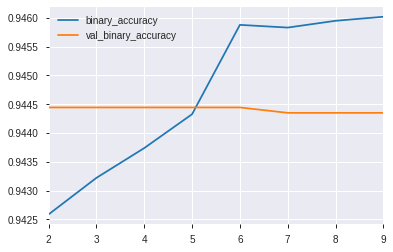

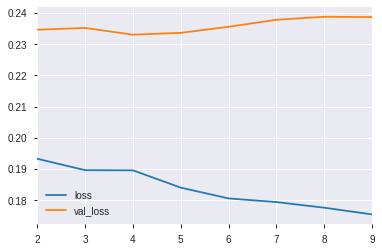

<IPython.core.display.Javascript object>

In [85]:
show_history(history, contains="acc", skip=2)
show_history(history, contains="loss", skip=2)